In [29]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.integrate import quad # Integration

from sklearn.neighbors import KernelDensity

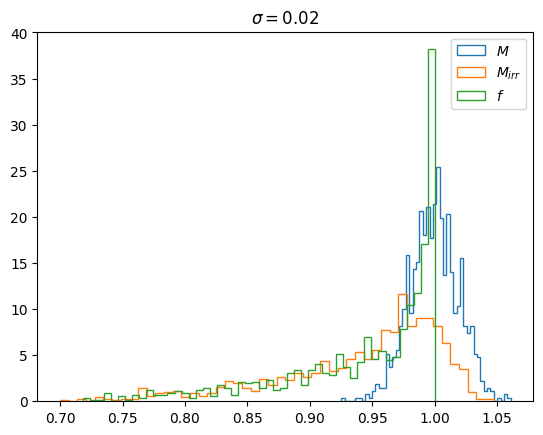

In [30]:
N = 1000 # Number of measurments
mu = 1

N_sigmas = 100 # Number of sigmas to test
sigmas = np.linspace(0.02, 2, N_sigmas) # A set of sigmas

nbins = 50

chi = np.random.uniform(0, 1, N)
M = np.array([np.random.normal(mu, sigmas[i], N) for i in range(N_sigmas)])

f = ((1 + (1 - chi ** 2) ** (1 / 2)) / 2) ** (1 / 2)
M_irr = f * M

watching_index = 0 # Index of sigmas you want to plot

# Plot of the distributions of M, M_irr, f for the (watching_index+1)-th sigma
plt.hist(M[watching_index], nbins, density=True, histtype='step', label='$M$')
plt.hist(M_irr[watching_index], nbins, density=True, histtype='step', label='$M_{irr}$')
plt.hist(f, nbins, density=True, histtype='step', label='$f$')

plt.title("$\sigma=$" + str(sigmas[watching_index]))
plt.legend()

In [31]:
# Define a mass grid for every distribution of M_irr
M_irr_grid = np.array([np.linspace(np.min(M_irr[i]), np.max(M_irr[i]), N) for i in range(N_sigmas)])

# KDE funtion
def kde_sklearn(x_grid, data, bandwidth=1.0, kernel='linear'):
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

# Calculate the KDE for every sample of M_irr with its own sigma
# Bandwith set to sigma as a general guess for a good value
M_irr_kdes = np.array([kde_sklearn(M_irr_grid[i], M_irr[i], bandwidth=sigmas[i], kernel='gaussian') for i in range(N_sigmas)])

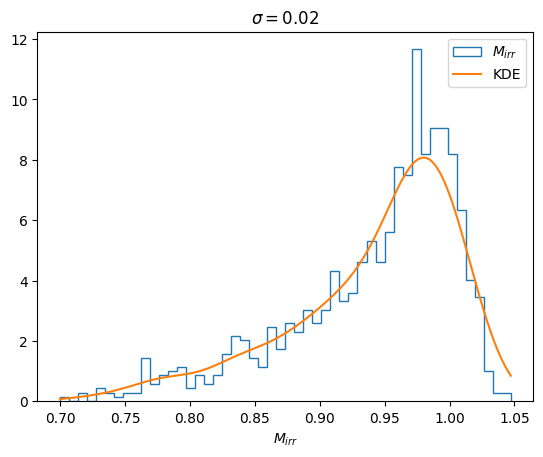

In [32]:
watching_index = 0

# Plot of the data and the KDE
plt.hist(M_irr[watching_index], nbins, density=True, histtype='step', label='$M_{irr}$')
plt.plot(M_irr_grid[watching_index], M_irr_kdes[watching_index], label='KDE')

plt.title("$\sigma=$" + str(sigmas[watching_index]))
plt.xlabel("$M_{irr}$")
plt.legend()

In [33]:
# KS test for between M_irr and f, for every sigma
KS_M_irr_f = np.array([stats.ks_2samp(M_irr[i], f).pvalue for i in range(N_sigmas)])

# KS test for between M_irr and M, for every sigma
KS_M_irr_M = np.array([stats.ks_2samp(M_irr[i], M[i]).pvalue for i in range(N_sigmas)])

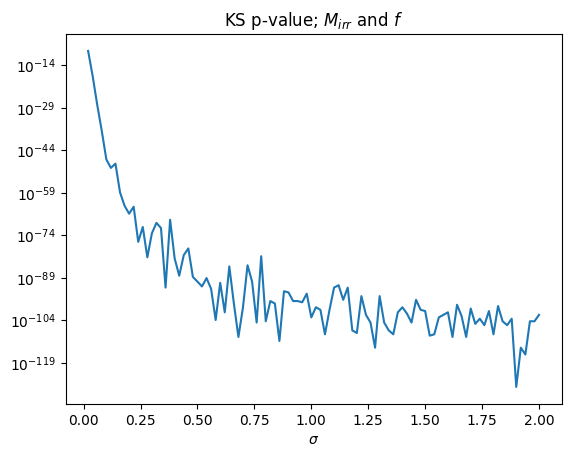

In [34]:
# Plot of the KS test p-value as a fucntion of sigma for M_irr and f
plt.plot(sigmas, KS_M_irr_f)

plt.title("KS p-value; $M_{irr}$ and $f$")
plt.xlabel("$\sigma$")
plt.yscale('log')

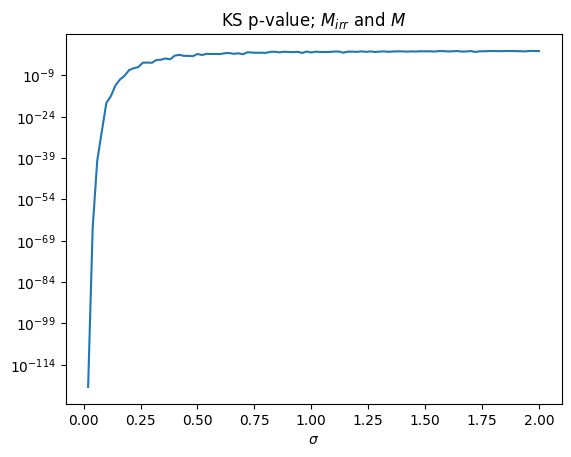

In [35]:
# Plot of the KS test p-value as a fucntion of sigma for M_irr and M
plt.plot(sigmas, KS_M_irr_M)

plt.title("KS p-value; $M_{irr}$ and $M$")
plt.xlabel("$\sigma$")
plt.yscale('log')

# __PDF of__ $f(\chi)$

If $x$ is a random variable and $y=f(x)$:
\begin{align*}
p(y)=\lvert dy/dx \rvert^{-1}p(x)
\end{align*}
where in our case x is unifromly distributed between $0$ and $1$ and $p(x)=1$. See [L02](https://github.com/dgerosa/astrostatistics_bicocca_2024/blob/main/lectures/L02_probability.ipynb) for reference.

With $f=y$ and $\chi=x$ we have:
\begin{gather*}
y=\sqrt{\frac{1+\sqrt{1-x^2}}{2}}\\
\sqrt{1-x^2}=2y^2-1\\
x=2y\sqrt{1-y^2}
\end{gather*}
Computing the derivative:
\begin{align*}
\frac{dy}{dx}=\frac{1}{2}\frac{1}{y}(\frac{1}{2}\frac{1}{2}\frac{1}{\sqrt{1-x^2}})(-2x)=-\frac{1}{4y}\frac{x}{\sqrt{1-x^2}}=-\frac{1}{4y}\frac{2y\sqrt{1-y^2}}{2y^2-1}=-\frac{1}{2}\frac{\sqrt{1-y^2}}{2y^2-1}
\end{align*}
Therefore:
\begin{align*}
p_f(f)=\lvert dy/dx \rvert^{-1}=2\frac{2f^2-1}{\sqrt{1-f^2}}
\end{align*}

# __PDF of__ $M_{irr}$

Since $M_{irr}=f(\chi)\times M$, we can use the following [theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables):

If $X$ and $Y$ are two independent, continuous random variables, described by probability density functions $f_X$ and $f_Y$ then the probability density function of $Z=XY$ is:
\begin{align*}
f_Z(z)=\int_{-\infty}^\infty f_X(x)f_Y(z/x)\frac{1}{\lvert x \rvert}dx
\end{align*}

The PDF of $M$ is a gaussian: $\mathcal{N}(M,\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(M-\mu)^2}{2\sigma^2})$ and the PDF of $f(\chi)$ has been computed above. Taking $p_f$ as $f_X$ yields:
\begin{align*}
p_{M_{irr}}(M_{irr})=\int_{1/\sqrt{2}}^1p_f(f)\mathcal{N}(M_{irr}/f,\mu,\sigma)\frac{1}{f}df
\end{align*}
Integration extremes are the limits of $f$. The integral should be evaluated numerically.

In [36]:
def f_pdf(f):
    return 2 * (2 * f ** 2 - 1) / (1 - f ** 2) ** (1 / 2)

# PDF of M_irr
def M_irr_pdf(M_irr, mu, sigma):
    f_func = lambda f: f_pdf(f) / f
    M_irr_pdf_integrand = lambda f, M_irr, mu, sigma: stats.norm.pdf(M_irr/f, mu, sigma) * f_func(f)
    
    return quad(M_irr_pdf_integrand, 1 / (2 ** (1 / 2)), 1, args=(M_irr, mu, sigma))[0]

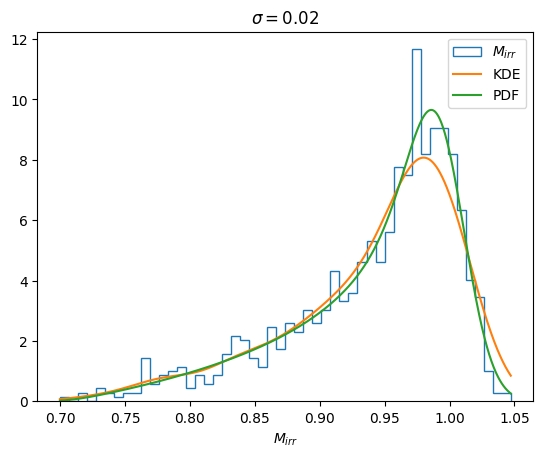

In [37]:
watching_index = 0

# Computed just for the watching_index beacuse requires a bit
M_irr_pdf_watching_index = np.array([M_irr_pdf(M_irr_grid[watching_index][i], mu, sigmas[watching_index]) for i in range(N)])

plt.hist(M_irr[watching_index], nbins, density=True, histtype='step', label='$M_{irr}$')
plt.plot(M_irr_grid[watching_index], M_irr_kdes[watching_index], label='KDE')
plt.plot(M_irr_grid[watching_index], M_irr_pdf_watching_index, label='PDF')

plt.title("$\sigma=$" + str(sigmas[watching_index]))
plt.xlabel("$M_{irr}$")
plt.legend()